## Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import yaml
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings("ignore")
import seaborn as sns
from settings import (
    SPEED_DATA_PATH,
    WIND_DATA_PATH, 
    GEO_PATH
)
from sz.SZ3.tools.pysz.pysz import SZ
from compress.sprintz_encode import compress_sprintz, decompress_sprintz, get_compress_info_sprintz
from compress.bypass import spatial_clustering
from compress.general_functions import get_errors, get_geo_dict, create_geo_plot
from compress.xor_encode import xor_compress_df, get_compress_info_xor, decompress_xor_df
from compress.lz4_encode import LZ4_compress_df, LZ4_decompress_df, get_compress_info_lz4
from compress.spatial_lz4 import spatial_clustering_PCA_LZ4, spatial_lz4_decompress, get_compress_info_spatial_PCA_LZ4, lz4_one
from compress.spatial_xor import spatial_clustering_xor, spatial_XOR_decompress, get_compress_info_spatial_xor
from compress.spatial_sprintz import spatial_clustering_sprintz, spatial_sprintz_decompress, get_compress_info_spatial_sprintz
from compress.sz3_encode import compress_sz3_df, decompress_sz3, get_compress_info_sz3, compress_sz3_all
from compress.cnn_encode import compress_cnn_sz3, decomress_cnn_sz3, get_compress_info_cnn_sz3

2025-04-17 00:46:44.078872: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Params

In [2]:
table_params = [{
                'selector': 'caption',
                'props': [
                    ('color', 'Blue'),
                    ('font-size', '16pt'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('caption-side', 'top'),
                    ('padding', '10px')
                ]
            },
            {
                'selector': 'th',
                'props': [('font-size', '14pt')]
            }]

## Data

### Download dataset

In [3]:
# int time series
speed_init = pd.read_csv(SPEED_DATA_PATH, parse_dates=[0], index_col=[0])# данные заполненности дорог
speed_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-08-31 18:22:00 to 2015-09-17 16:24:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2500 non-null   int64
dtypes: int64(1)
memory usage: 39.1 KB


In [4]:
speed_init['index'] = np.arange(speed_init.shape[0])
sensor_data = {}

for i in range(5):
    sensor_data[f'sensor_{i+1}'] = speed_init.loc[speed_init['index'] % 5 == i,
                                             ['value']]['value'].to_list()

df_speed = pd.DataFrame(sensor_data)
print('DataFrame shape:', df_speed.shape)
df_speed.head()

DataFrame shape: (500, 5)


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,90,80,84,94,90
1,91,62,96,75,84
2,86,93,69,88,71
3,74,68,88,71,87
4,82,68,73,69,57


In [5]:
df_speed.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,82.126000,81.538000,81.862000,81.786000,82.222000
std,8.404963,9.247897,8.155488,8.913085,8.983659
min,43.000000,28.000000,53.000000,29.000000,20.000000
25%,77.000000,76.000000,77.000000,76.000000,77.000000
50%,83.000000,82.000000,82.000000,82.000000,83.000000
75%,87.000000,88.000000,87.000000,88.000000,88.000000
max,109.000000,103.000000,106.000000,106.000000,105.000000


In [6]:
df_wind = pd.read_csv(WIND_DATA_PATH)
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_1  5371 non-null   float64
 2   sensor_2  5371 non-null   float64
 3   sensor_3  5371 non-null   float64
 4   sensor_4  5371 non-null   float64
 5   sensor_5  5371 non-null   float64
dtypes: float64(6)
memory usage: 251.9 KB


In [7]:
df_wind.describe()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000
mean,0.227920,0.200216,0.250895,0.226237,0.210789,0.170282
std,0.183147,0.194221,0.228161,0.186192,0.204030,0.158362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.071329,0.035002,0.043961,0.067200,0.037736,0.035301
50%,0.186014,0.139327,0.182703,0.176465,0.142235,0.121945
75%,0.370629,0.323170,0.428663,0.364866,0.348337,0.278338
max,0.683916,0.783491,0.871451,0.709350,0.791937,0.655671


### Creating wind Dataset

Возьмем данные о первых шести ветренных вышек.

In [8]:
# df_wind = df_wind_init[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']]
# df_wind = df_wind.head(10000)

Видим, что данные ненулевые через определенные промежутки времени. Это связано с тем, что отсутствует непрерывность замеров данных. Оставим только те строки, где есть хотя бы одно ненулевое значение.

In [9]:
# Ensure the correct columns are used
# df_wind = df_wind.loc[(
#     df_wind[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']] != 0).any(axis=1)].reset_index(drop=True)
# df_wind.columns = [f'sensor_{i}' for i in range(df_wind.shape[1])]
# df_wind.info()

In [10]:
#df_wind.to_csv('data/wind_df.csv', index=False) # save test dataframe

## Data analisys

In [11]:
corr_wind = df_wind.corr()
styled_corr_wind = corr_wind.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# Отображение матрицы корреляции
display(styled_corr_wind)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_0,1.000000,0.692844,0.718031,0.858738,0.901123,0.844601
sensor_1,0.692844,1.000000,0.533855,0.723919,0.705373,0.862921
sensor_2,0.718031,0.533855,1.000000,0.637662,0.685302,0.661292
sensor_3,0.858738,0.723919,0.637662,1.000000,0.772007,0.839008
sensor_4,0.901123,0.705373,0.685302,0.772007,1.000000,0.884198
sensor_5,0.844601,0.862921,0.661292,0.839008,0.884198,1.000000


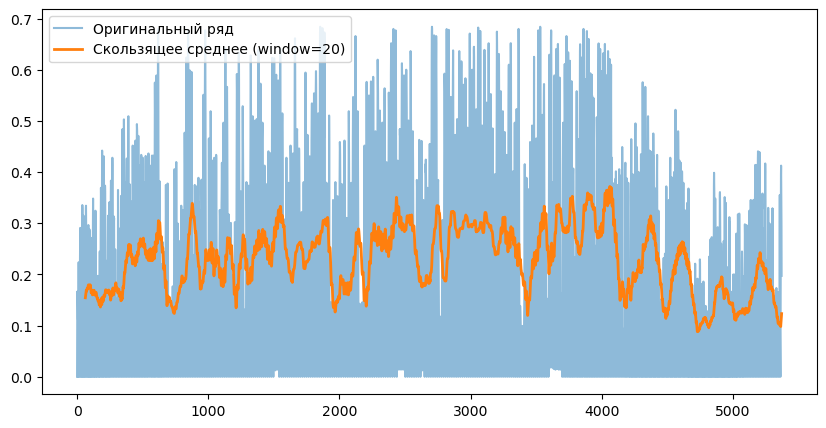

In [12]:
rolling_mean = df_wind.sensor_0.rolling(window=64).mean()

plt.figure(figsize=(10,5))
plt.plot(df_wind.sensor_0.values, label="Оригинальный ряд", alpha=0.5)
plt.plot(rolling_mean, label="Скользящее среднее (window=20)", linewidth=2)
plt.legend()
plt.show()

## Geo data

### For NAB

In [13]:
# # create for speed
# def get_geo_dict(df):
#     # make geo data
#     sen_num = df.shape[1]
#     x_y = []
#     for i in range(sen_num):
#         x_y.append([rn.uniform(.0, 6.0), rn.uniform(.0, 6.0)])
#         print(f'sensor_{i}:', x_y[i])
#     plt.grid(True)
#     for i in range(len(x_y)):
#         plt.plot(x_y[i][0], x_y[i][1], 'o', label = i)
#         plt.legend(loc = 'best', fancybox = True, shadow = True)
#     plt.plot(3*np.ones(300), np.arange(0, 6, 0.02))
#     plt.plot(np.arange(0, 6, 0.02), 3*np.ones(300))
#     geo_dict = dict(zip(df.columns, x_y))
#     print(geo_dict)
#     return dict(zip(df.columns, x_y))

sensor_0: [4.4455303846733125, 4.559755899043662]
sensor_1: [5.459187258496657, 0.7240403912934215]
sensor_2: [4.204643811015124, 4.699612290957969]
sensor_3: [1.0988049236239161, 0.6509889514870284]
sensor_4: [3.8271892505769642, 3.4463909445037912]


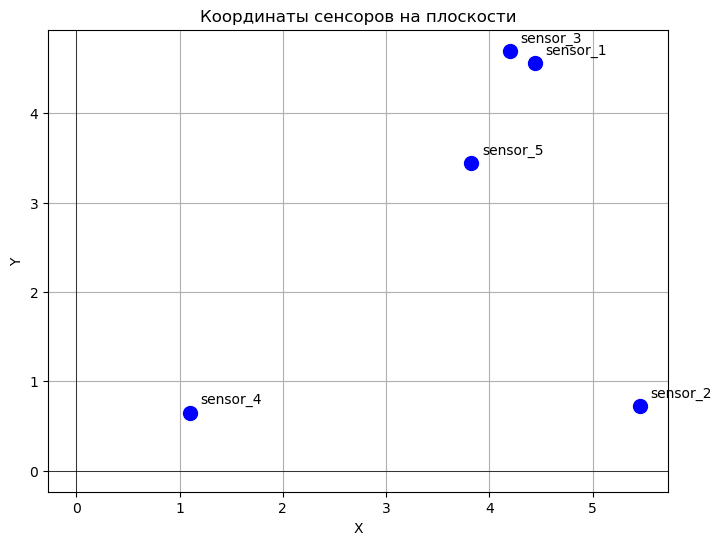

In [14]:
speed_geo_dict = get_geo_dict(df_speed)
create_geo_plot(speed_geo_dict)

### For wind

In [15]:
# create geo dict for wind dataset
# wind_geo_dict = get_geo_dict(df_wind)
# create_geo_plot(wind_geo_dict)

In [16]:
# print('Clusters for Emhires dataset:')
# spatial_clustering(df_wind, wind_geo_dict)

{'sensor_0': [1.1, 4.2], 'sensor_1': [4.3, 1.9], 'sensor_2': [5.1, 2.6], 'sensor_3': [0.5, 5.0], 'sensor_4': [1.2, 3.8], 'sensor_5': [2.12, 3.9]}


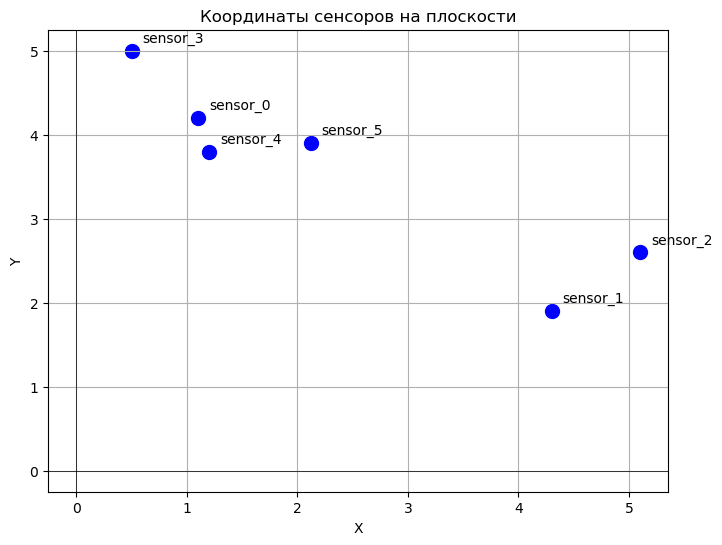

In [17]:
with open(GEO_PATH / 'wind_geo_dict.yaml', 'r') as file:
    wind_geo_dict = yaml.safe_load(file)

print(wind_geo_dict)
create_geo_plot(wind_geo_dict)

In [18]:
#check bypassing for clustering
print('Clusters for Emhires dataset:')
spatial_clustering(df_wind, wind_geo_dict)

Clusters for Emhires dataset:


{'sensor_0': ['sensor_0', 'sensor_4', 'sensor_3', 'sensor_5'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2']}

## Sprintz

In [19]:
speed_sprintz_res = compress_sprintz(df=df_speed, chunk_size=8)

In [20]:
# Check for equals decodind and original data
decode_res = decompress_sprintz(speed_sprintz_res, num_cols = 5, chunk_size=7)
decode_res.columns = df_speed.columns
print('Check for decode:', df_speed.equals(decode_res))

Check for decode: True


In [21]:
get_compress_info_sprintz(df_speed, speed_sprintz_res)

Размер исходных данных: 2179 байт 

Размер сжатых данных: 1973 байт 

Коэффициент сжатия: 1.104


## XOR

In [22]:
compressed_df = xor_compress_df(df_wind)
decompressed_df = decompress_xor_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [23]:
get_compress_info_xor(df_wind, compressed_df)

Размер исходных данных: 257808 байт 

Размер сжатых XOR данных: 249461 байт 

Коэффициент сжатия: 1.033


## LZ4

In [24]:
compressed_df = LZ4_compress_df(df_wind)
decompressed_df = LZ4_decompress_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [25]:
get_compress_info_lz4(df_wind, compressed_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 191643 байт 

Коэффициент сжатия: 1.345


## Spatial + XOR

In [26]:
#todo solve problems where dif
df = df_wind.round(15)

In [27]:
res = spatial_clustering_xor(df, wind_geo_dict)
decompressed_df = spatial_XOR_decompress(res)
print('Check for decode:', decompressed_df.equals(df))

Check for decode: True


In [28]:
get_compress_info_spatial_xor(df, res)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 255656.625 байт 

Коэффициент сжатия: 1.008


## Spatial + Sprintz

In [29]:
df = df_wind*100
df = df.astype(int)

In [30]:
res = spatial_clustering_sprintz(df.copy(), wind_geo_dict, 0.84)

In [31]:
clust_dict = spatial_clustering(
    df, wind_geo_dict, 0.84)
decode_res = spatial_sprintz_decompress(res,
                                        clust_dict)
print('Check for decode:', df.equals(decode_res))

Check for decode: True


In [32]:
get_compress_info_spatial_sprintz(df, res)

Размер исходных данных: 16428 байт 

Размер сжатых данных: 42420 байт 

Коэффициент сжатия: 0.387


## Spatial + PCA + LZ4

In [33]:
res = spatial_clustering_PCA_LZ4(df_wind, wind_geo_dict)

In [34]:
get_compress_info_spatial_PCA_LZ4(df_wind, res)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 148924 байт 

Коэффициент сжатия: 1.731


In [35]:
clusters = spatial_clustering(df_wind, wind_geo_dict)
dec_res = spatial_lz4_decompress(res, clusters)
get_errors(df_wind, dec_res)

MSE: 0.001079 

MAPE: 13.78 %


## SZ3

In [36]:
data_enc = compress_sz3_df(df_wind)

In [37]:
get_compress_info_sz3(df_wind, data_enc)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 12635 байт 

Коэффициент сжатия: 20.404


In [38]:
data = df_wind.values.transpose()
shape = [d.shape for d in data]
type = data[0].dtype
data_dec = decompress_sz3(data_enc, shape, type)
get_errors(df_wind, data_dec)

MSE: 0.000271 

MAPE: 20.64 %


In [39]:
# compress whole data
data = df_wind.values.transpose()
data_enc = compress_sz3_all(df_wind)

In [40]:
get_compress_info_sz3(df_wind, data_enc)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 11523 байт 

Коэффициент сжатия: 22.373


In [41]:
data_dec = decompress_sz3(data_enc, data.shape, data.dtype)
get_errors(df_wind, data_dec)

MSE: 0.000263 

MAPE: 22.64 %


## SZ + Conv

In [42]:
enc_df = compress_cnn_sz3(df_wind, wind_geo_dict)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0887
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0350
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0204
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 16/50
83/83 ━

INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5766023648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5766024704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5766023824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5766023296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5766025584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5766022592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5766024000: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1744840034.253520 13300483 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1744840034.253572 13300483 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-04-17 00:47:14.254111: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-17 00:47:14.255091: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-17 00:47:14.255108: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-17 00:47:14.269542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-04-17 00:47:14.270863: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-17 00:47:14.322430: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-17 00:47:14.341414: I tensorflow/cc/saved_model/loader.cc:317] SavedMo

In [43]:
get_compress_info_cnn_sz3(df_wind, enc_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 12257 байт 

Коэффициент сжатия: 21.034


In [44]:
dec_df = decomress_cnn_sz3(enc_df, (5371,))
dec_df = dec_df.sort_index(axis=1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [45]:
get_errors(df_wind, dec_df)

MSE: 0.005015 

MAPE: 53.52 %
